In [2]:
!nvidia-smi

Fri Nov 29 15:59:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8               2W /  80W |  10521MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from utils import *

from tqdm import tqdm,trange
import torchvision.utils as vutils
from IPython.display import Image, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

# Load VAE and check sanity

In [13]:
class VAE_BatchPrep(BatchPrepareBase):
    def process(self, x):
        return x.cuda()

In [14]:
class VAE_Sampler(SamplerBase):

    def calc(self,model,num):
        return model.decode(torch.randn(num, model.latent_dim).cuda())
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x_data = next(iter(test_loader))[0][:num].cuda()
        
        # generation
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_gen.png')
        
        # reconstruction
        
        mu, logvar = model.encode(x_data)
        x_recon = model.decode(mu+torch.randn_like(mu)*torch.exp(logvar/2))
        grid = vutils.make_grid(x_recon, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_recon.png')
        grid = vutils.make_grid(x_data, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_data.png')
        
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [15]:
from vae import VAE
vae_model = VAE().cuda()
print('number of parameters:', sum(p.numel() for p in vae_model.parameters()))
vae_model.load_state_dict(torch.load('checkpoints/ep50_vae.pth'))

number of parameters: 944600


/tmp/ipykernel_14761/2768480163.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('checkpoints/ep50_vae.pth'))


<All keys matched successfully>

torch.Size([64, 1, 28, 28])


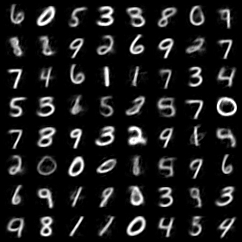

In [16]:
# noise vae generation
sampler = VAE_Sampler()
with torch.no_grad():
    x = sampler.calc(vae_model, 64)
    print(x.shape)
x_vae = x
grid = vutils.make_grid(x_vae, nrow=8)
vutils.save_image(grid, f'samples/test_vae_sanity.png')
display(Image(filename=f'samples/test_vae_sanity.png'))

# Load DDPM and check sanity

In [62]:
# cosine schedule
from math import pi
T = 1000
angles = torch.linspace(0.1, pi-0.1, T)
alpha_bars = (1 + torch.cos(angles)) / 2
alphas = torch.ones_like(alpha_bars,dtype=torch.float)
alphas[1:] = alpha_bars[1:] / alpha_bars[:-1]
sigmas = torch.sqrt(1-alphas)
alpha_bars[::100]

tensor([0.9975, 0.9616, 0.8860, 0.7771, 0.6444, 0.4993, 0.3542, 0.2217, 0.1131,
        0.0378])

In [39]:
from vanilla_unet import UNet
model = UNet().cuda()
model = nn.DataParallel(model)
print('model params:', sum(p.numel() for p in model.parameters()))
model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm.pth'))

model params: 6065665


/tmp/ipykernel_11847/632335827.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm.pth'))


<All keys matched successfully>

In [ ]:
class DDPM_Sampler_test(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        
    def calc(self,model,x0,num):
        x = x0
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_halfddpm_init.png')
        
        for t in trange(self.max_T-1,-1,-1):
            w1 = 1/torch.sqrt(alphas[t]).cuda()
            w2 = (1-alphas[t])/torch.sqrt(1-alpha_bars[t]).cuda()
            x = w1 * (x - w2 * model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))) + sigmas[t].cuda().reshape(-1,1,1,1) * torch.randn_like(x)
        
        return x

    @torch.no_grad()
    def sample(self, model, x0, num, desc):
        x = self.calc(model, x0,num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.61it/s]


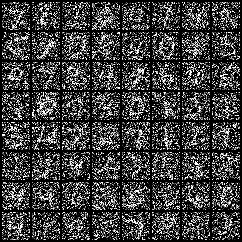

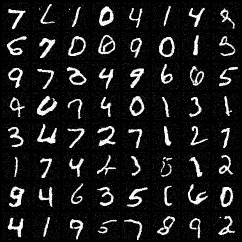

In [19]:
# from test loader
x = next(iter(test_loader))[0][:64].cuda()
noise = torch.randn_like(x)
x0 = (x + noise)/torch.sqrt(torch.tensor(2.))

# sample
sampler = DDPM_Sampler_test()
sampler.sample(model, x0, 64, 'test_halfddpm_sample_dataset')

display(Image(filename=f'samples/test_halfddpm_init.png'))
display(Image(filename=f'samples/test_halfddpm_sample_dataset.png'))

# Merged evaluation

In [15]:
# make sure we have no access to data from now
del train_dataset,test_dataset,train_loader,test_loader

## 1. Different NFE

In [37]:
class Merged_DDPM_VAE_Sampler(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        self.vae_sampler = VAE_Sampler()
        # self.ddpm_sampler = DDPM_Sampler_test(max_T)
    
    @torch.no_grad()    
    def sample(self,vae_model,ddpm_model,num,desc=''):
        # we ensure that the same random seed is used
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        x_vae = self.vae_sampler.calc(vae_model,num)
        grid = vutils.make_grid(x_vae, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_vae_{self.max_T}.png')
        
        x = x_vae * torch.sqrt(alpha_bars[self.max_T-1]) + torch.randn_like(x_vae) * torch.sqrt(1-alpha_bars[self.max_T-1])
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_noisy_{self.max_T}.png')
        
        for t in trange(self.max_T-1,-1,-1):
            w1 = 1/torch.sqrt(alphas[t]).cuda()
            w2 = (1-alphas[t])/torch.sqrt(1-alpha_bars[t]).cuda()
            x = w1 * (x - w2 * ddpm_model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))) + sigmas[t].cuda().reshape(-1,1,1,1) * torch.randn_like(x)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_gen_{self.max_T}.png')
        return x


Base: 500 (reduce NFE by half)

max_T: 500


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.21it/s]


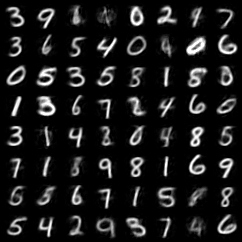

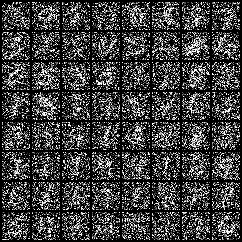

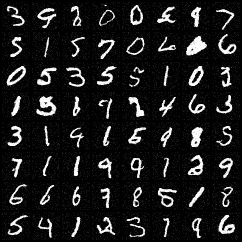

In [28]:
max_T = 500
print('max_T:',max_T)
sampler = Merged_DDPM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64)
display(Image(filename=f'samples/test_merged_vae_{max_T}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}.png'))
display(Image(filename=f'samples/test_merged_gen_{max_T}.png'))

NFE: 400

max_T: 400


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 50.36it/s]


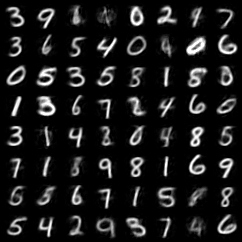

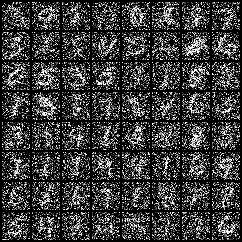

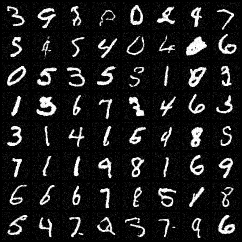

In [29]:
max_T = 400
print('max_T:',max_T)
sampler = Merged_DDPM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64)
display(Image(filename=f'samples/test_merged_vae_{max_T}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}.png'))
display(Image(filename=f'samples/test_merged_gen_{max_T}.png'))

NFE: 300

max_T: 300


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.21it/s]


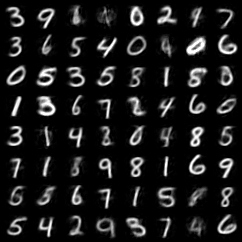

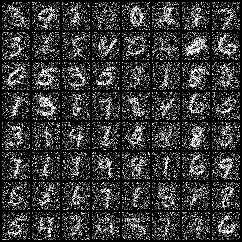

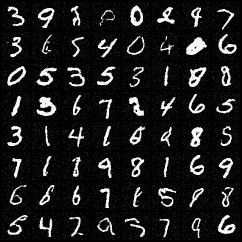

In [30]:
max_T = 300
print('max_T:',max_T)
sampler = Merged_DDPM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64)
display(Image(filename=f'samples/test_merged_vae_{max_T}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}.png'))
display(Image(filename=f'samples/test_merged_gen_{max_T}.png'))

NFE: 200

max_T: 200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.97it/s]


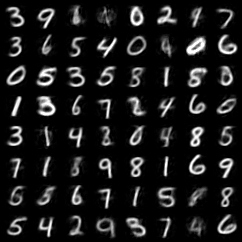

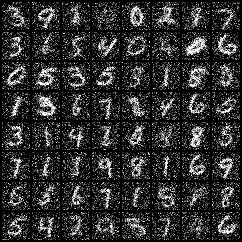

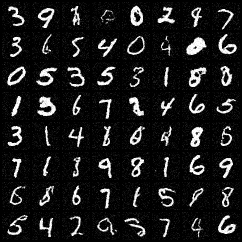

In [31]:
max_T = 200
print('max_T:',max_T)
sampler = Merged_DDPM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64)
display(Image(filename=f'samples/test_merged_vae_{max_T}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}.png'))
display(Image(filename=f'samples/test_merged_gen_{max_T}.png'))

NFE: 100

max_T: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.69it/s]


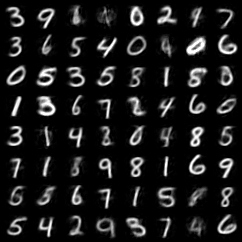

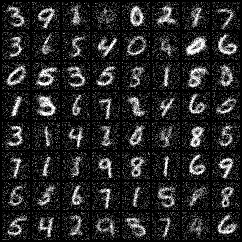

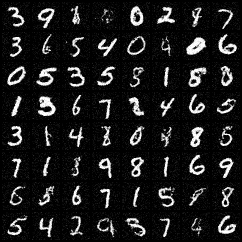

In [32]:
max_T = 100
print('max_T:',max_T)
sampler = Merged_DDPM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64)
display(Image(filename=f'samples/test_merged_vae_{max_T}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}.png'))
display(Image(filename=f'samples/test_merged_gen_{max_T}.png'))

## 2. Smaller model

In [34]:
from vanilla_unet import UNet
small_model = UNet(nf=64).cuda()
small_model = nn.DataParallel(small_model)
print('model params:', sum(p.numel() for p in small_model.parameters()))
small_model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm_small.pth'))

model params: 1521409


/tmp/ipykernel_11847/3102003214.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  small_model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm_small.pth'))


<All keys matched successfully>

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.16it/s]


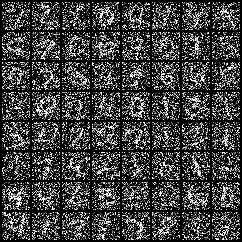

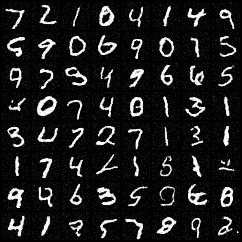

In [36]:
from utils import test_loader
# from test loader
x = next(iter(test_loader))[0][:64].cuda()
noise = torch.randn_like(x)
x0 = (x + noise)/torch.sqrt(torch.tensor(2.))

# sample
sampler = DDPM_Sampler_test()
sampler.sample(small_model, x0, 64, 'test_halfddpm_small_sample_dataset')

display(Image(filename=f'samples/test_halfddpm_init.png'))
display(Image(filename=f'samples/test_halfddpm_small_sample_dataset.png'))

### Merged evaluation

max_T: 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.76it/s]


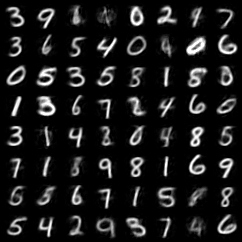

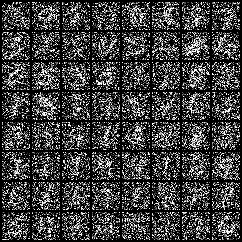

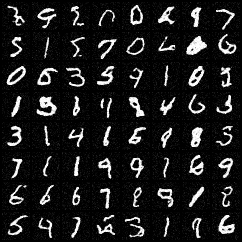

In [38]:
max_T = 500
print('max_T:',max_T)
sampler = Merged_DDPM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64,desc='_small')
display(Image(filename=f'samples/test_merged_small_vae_{max_T}.png'))
display(Image(filename=f'samples/test_merged_small_noisy_{max_T}.png'))
display(Image(filename=f'samples/test_merged_small_gen_{max_T}.png'))

## 3. Influence of mean

In [44]:
class Merged_DDPM_VAE_Sampler_Scale(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        self.vae_sampler = VAE_Sampler()
        # self.ddpm_sampler = DDPM_Sampler_test(max_T)
    
    @torch.no_grad()    
    def sample(self,vae_model,ddpm_model,num,desc='',scale=1.):
        # we ensure that the same random seed is used
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        x_vae = self.vae_sampler.calc(vae_model,num) * scale
        grid = vutils.make_grid(x_vae, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_vae_{self.max_T}_scale{scale:.3f}.png')
        
        x = x_vae * torch.sqrt(alpha_bars[self.max_T-1]) + torch.randn_like(x_vae) * torch.sqrt(1-alpha_bars[self.max_T-1])
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_noisy_{self.max_T}_scale{scale:.3f}.png')
        
        for t in trange(self.max_T-1,-1,-1):
            w1 = 1/torch.sqrt(alphas[t]).cuda()
            w2 = (1-alphas[t])/torch.sqrt(1-alpha_bars[t]).cuda()
            x = w1 * (x - w2 * ddpm_model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))) + sigmas[t].cuda().reshape(-1,1,1,1) * torch.randn_like(x)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_gen_{self.max_T}_scale{scale:.3f}.png')
        return x


max_T: 300
scale: 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 49.89it/s]


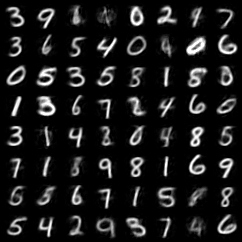

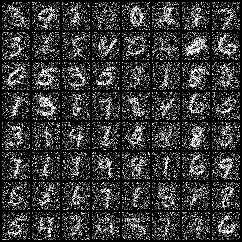

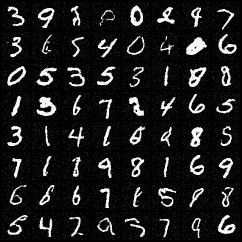

In [45]:
max_T = 300
scale = 1.0
print('max_T:',max_T)
print('scale:',scale)
sampler = Merged_DDPM_VAE_Sampler_Scale(max_T=max_T)
x = sampler.sample(vae_model,model,64,scale=scale)
display(Image(filename=f'samples/test_merged_vae_{max_T}_scale{scale:.3f}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}_scale{scale:.3f}.png'))
display(Image(filename=f'samples/test_merged_gen_{max_T}_scale{scale:.3f}.png'))

max_T: 300
scale: 1.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.33it/s]


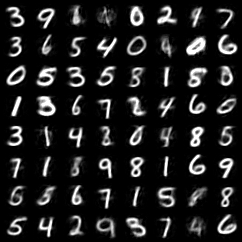

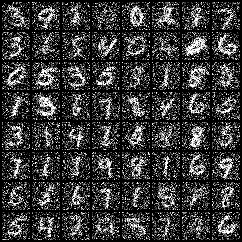

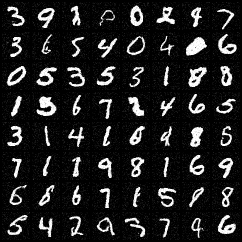

In [46]:
max_T = 300
scale = 1.2
print('max_T:',max_T)
print('scale:',scale)
sampler = Merged_DDPM_VAE_Sampler_Scale(max_T=max_T)
x = sampler.sample(vae_model,model,64,scale=scale)
display(Image(filename=f'samples/test_merged_vae_{max_T}_scale{scale:.3f}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}_scale{scale:.3f}.png'))
display(Image(filename=f'samples/test_merged_gen_{max_T}_scale{scale:.3f}.png'))

## 4. ODE Sampler (DDIM)

In [75]:
from vanilla_unet import UNet
model = UNet().cuda()
model = nn.DataParallel(model)
print('model params:', sum(p.numel() for p in model.parameters()))
model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm.pth'))

model params: 6065665


/tmp/ipykernel_11847/632335827.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm.pth'))


<All keys matched successfully>

In [76]:
class DDIM_Sampler_test(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        
    def calc(self,model,x0,num):
        x = x0
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_halfddpm_ddim_sample_init.png')
        
        for t in trange(self.max_T-1,1,-1):
            eps = model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))
            x = (x - torch.sqrt(1-alpha_bars[t])*eps)/torch.sqrt(alphas[t])+torch.sqrt(1-alpha_bars[t]/alphas[t])*eps
            # x = (x - (1-alphas[t])/torch.sqrt(1-alpha_bars[t])*eps)/torch.sqrt(alphas[t])+torch.sqrt(1-alphas[t])*torch.randn_like(x)
            
        return x

    @torch.no_grad()
    def sample(self, model, x0, num, desc):
        x = self.calc(model, x0,num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:09<00:00, 50.84it/s]


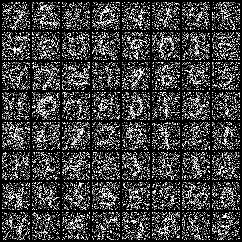

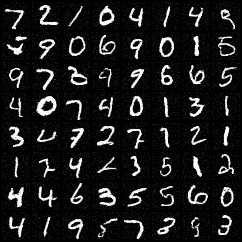

In [78]:
# from test loader
x = next(iter(test_loader))[0][:64].cuda()
noise = torch.randn_like(x)
x0 = (x + noise)/torch.sqrt(torch.tensor(2.))
# x0 = noise

# sample
sampler = DDIM_Sampler_test(max_T=500)
sampler.sample(model, x0, 64, 'test_halfddpm_ddim_sample_dataset')

display(Image(filename=f'samples/test_halfddpm_ddim_sample_init.png'))
display(Image(filename=f'samples/test_halfddpm_ddim_sample_dataset.png'))

In [79]:
# make sure we have no access to data from now
del train_dataset,test_dataset,train_loader,test_loader

In [80]:
class Merged_DDIM_VAE_Sampler(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        self.vae_sampler = VAE_Sampler()
        # self.ddpm_sampler = DDPM_Sampler_test(max_T)
    
    @torch.no_grad()    
    def sample(self,vae_model,ddpm_model,num,desc=''):
        # we ensure that the same random seed is used
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        x_vae = self.vae_sampler.calc(vae_model,num)
        grid = vutils.make_grid(x_vae, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_vae_ddim_{self.max_T}.png')
        
        x = x_vae * torch.sqrt(alpha_bars[self.max_T-1]) + torch.randn_like(x_vae) * torch.sqrt(1-alpha_bars[self.max_T-1])
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_noisy_ddim_{self.max_T}.png')
        
        for t in trange(self.max_T-1,-1,-1):
            eps = ddpm_model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))
            x = (x - torch.sqrt(1-alpha_bars[t])*eps)/torch.sqrt(alphas[t])+torch.sqrt(1-alpha_bars[t]/alphas[t])*eps
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_gen_ddim_{self.max_T}.png')
        return x


max_T: 500


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.18it/s]


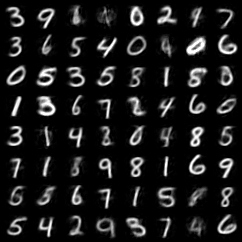

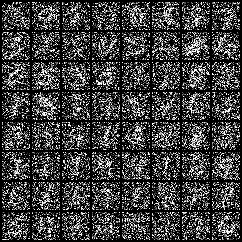

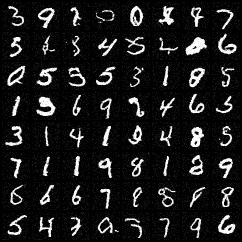

In [81]:
max_T = 500
print('max_T:',max_T)
sampler = Merged_DDIM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64)
display(Image(filename=f'samples/test_merged_vae_ddim_{max_T}.png'))
display(Image(filename=f'samples/test_merged_noisy_ddim_{max_T}.png'))
display(Image(filename=f'samples/test_merged_gen_ddim_{max_T}.png'))

## 5. Flow Matching models

### Sanity

In [9]:
import torchdiffeq
class FM_Sampler_test(SamplerBase):
    def __init__(self,max_T=0.5):
        self.max_T = max_T
    
    @torch.no_grad()
    def sample(self, model, x0, num, desc):
        @torch.no_grad()
        def f(t,x):
            return model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))
        
        x = torchdiffeq.odeint(f,x0,torch.tensor([self.max_T,0]),rtol=1e-5,atol=1e-5)[-1]
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')
        return x

In [6]:
from vanilla_unet import UNet
model = UNet().cuda()
model = nn.DataParallel(model)
print('model params:', sum(p.numel() for p in model.parameters()))
model.load_state_dict(torch.load('checkpoints/ep_50_half_fm.pth'))

model params: 6065665


/tmp/ipykernel_14761/3656092961.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/ep_50_half_fm.pth'))


<All keys matched successfully>

/home/zhh/anaconda3/envs/DYY/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


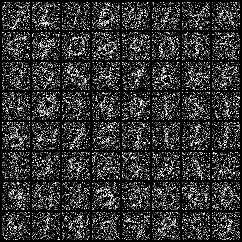

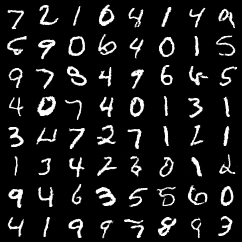

In [8]:
# from test loader
x = next(iter(test_loader))[0][:64].cuda()
noise = torch.randn_like(x)
x0 = (x + noise)/2

grid = vutils.make_grid(x0, nrow=8)
vutils.save_image(grid, f'samples/test_halffm_init.png')

# sample
sampler = FM_Sampler_test()
sampler.sample(model, x0, 64, 'test_halffm_sample_dataset')

display(Image(filename=f'samples/test_halffm_init.png'))
display(Image(filename=f'samples/test_halffm_sample_dataset.png'))

### Merged evaluation

In [18]:
class Merged_FM_VAE_Sampler(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        self.vae_sampler = VAE_Sampler()
        self.fm_sampler = FM_Sampler_test(max_T)
    
    @torch.no_grad()    
    def sample(self,vae_model,fm_model,num,desc=''):
        # we ensure that the same random seed is used
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        x_vae = self.vae_sampler.calc(vae_model,num)
        grid = vutils.make_grid(x_vae, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_vae_{self.max_T}.png')
        
        x = x_vae * (1-self.max_T) + torch.randn_like(x_vae) * self.max_T
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/test_merged{desc}_noisy_{self.max_T}.png')
        
        x = self.fm_sampler.sample(fm_model, x, num, f'test_merged{desc}_fm_gen_{self.max_T}')
        return x


max_T: 0.5


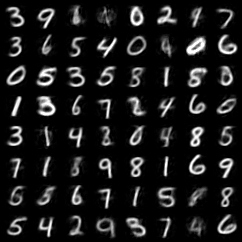

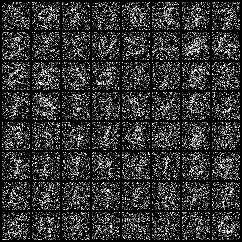

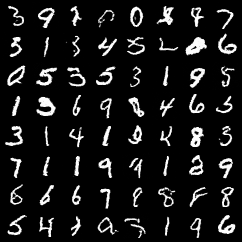

: 

In [ ]:
max_T = 0.5
print('max_T:',max_T)
sampler = Merged_FM_VAE_Sampler(max_T=max_T)
x = sampler.sample(vae_model,model,64)
display(Image(filename=f'samples/test_merged_vae_{max_T}.png'))
display(Image(filename=f'samples/test_merged_noisy_{max_T}.png'))
display(Image(filename=f'samples/test_merged_fm_gen_{max_T}.png'))